Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking
using CmdStan, StanMCMCChain
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "13")
cd(ProjDir)

### snippet 13.1

In [3]:
wd = CSV.read(rel_path("..", "data", "UCBadmit.csv"), delim=';');
df = convert(DataFrame, wd);

Preprocess data

In [4]:
df[:admit] = convert(Vector{Int}, df[:admit])
df[:applications] = convert(Vector{Int}, df[:applications])
df[:male] = [(df[:gender][i] == "male" ? 1 : 0) for i in 1:size(df, 1)];
df[:dept_id] = [Int(df[:dept][i][1])-64 for i in 1:size(df, 1)];
first(df, 5)

m13_2_model = "
  data{
      int N;
      int N_depts;
      int applications[N];
      int admit[N];
      real male[N];
      int dept_id[N];
  }
  parameters{
      vector[N_depts] a_dept;
      real a;
      real bm;
      real<lower=0> sigma_dept;
  }
  model{
      vector[N] p;
      sigma_dept ~ cauchy( 0 , 2 );
      bm ~ normal( 0 , 1 );
      a ~ normal( 0 , 10 );
      a_dept ~ normal( a , sigma_dept );
      for ( i in 1:N ) {
          p[i] = a_dept[dept_id[i]] + bm * male[i];
          p[i] = inv_logit(p[i]);
      }
      admit ~ binomial( applications , p );
  }
";

Define the Stanmodel and set the output format to :mcmcchain.

In [5]:
stanmodel = Stanmodel(name="m13_2_model", model=m13_2_model,
monitors=["a", "bm", "sigma_dept", "a_dept.1", "a_dept.2", "a_dept.3",
"a_dept.4", "a_dept.5", "a_dept.6"],
output_format=:mcmcchain);


File /Users/rob/.julia/dev/StatisticalRethinking/scripts/13/tmp/m13_2_model.stan will be updated.



Input data for cmdstan

In [6]:
ucdata = Dict("N" => size(df, 1), "N_depts" => maximum(df[:dept_id]), "admit" => df[:admit],
"applications" => df[:applications],  "dept_id"=> df[:dept_id], "male" => df[:male]);

Sample using cmdstan

In [7]:
rc, chn, cnames = stan(stanmodel, ucdata, ProjDir, diagnostics=false,
  summary=false, CmdStanDir=CMDSTAN_HOME);
# Describe the draws
describe(chn)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
               Mean         SD       Naive SE       MCSE      ESS
  a_dept.1  0.67482532 0.100637804 0.0015912234 0.0028595285 1000
  a_dept.2  0.63010342 0.117685812 0.0018607761 0.0027845476 1000
  a_dept.3 -0.58329619 0.074828996 0.0011831503 0.0012026455 1000
  a_dept.4 -0.61474940 0.086334651 0.0013650707 0.0016957938 1000
  a_dept.5 -1.05698382 0.098684157 0.0015603335 0.0018454593 1000
  a_dept.6 -2.60403903 0.154482180 0.0024425777 0.0025358629 1000
         a -0.59051962 0.634809702 0.0100372227 0.0100578387 1000
        bm -0.09466003 0.080738557 0.0012765887 0.0022817196 1000
sigma_dept  1.45893086 0.558455093 0.0088299503 0.0123178572 1000

Quantiles:
               2.5%       25.0%       50.0%       75.0%       97.5%   
  a_dept.1  0.48078733  0.60666200  0.6747215  0.741735500  0.87807695
  a_dept.2  0.40581530  0.54892800  0.6290385  0.711621500  0.85840288

Plot the density of posterior draws

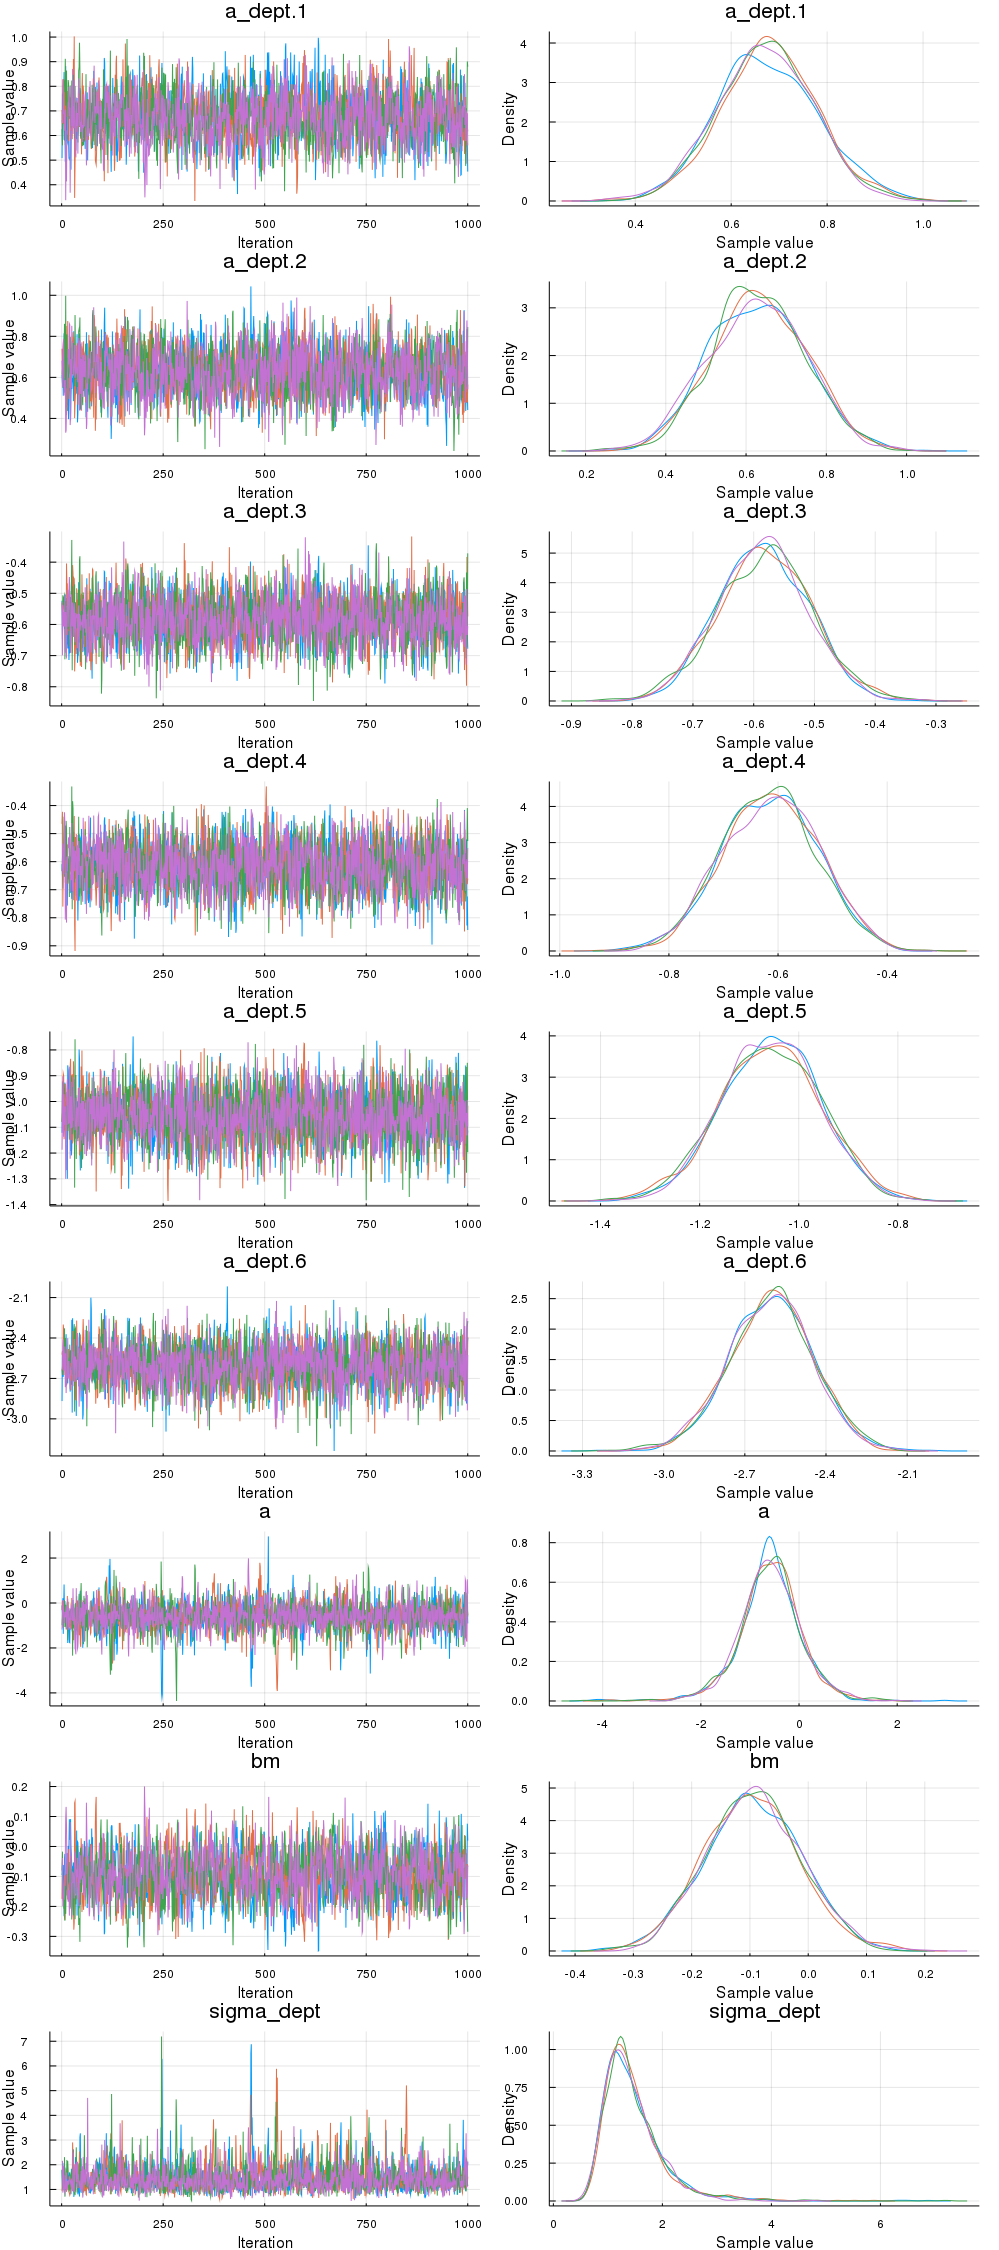

In [8]:
plot(chn)

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*